## 1. Data preparation


1.1 Importing libraries

In [1]:
import pandas as pd
import numpy as np
from numba import cuda
import torch.cuda
from google.colab import runtime
import torch
import numpy as np
import pandas as pd
import io
import os
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
!pip install datasets

from datasets import Dataset, load_metric
import json

from time import sleep

from collections import defaultdict
import numpy as np

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


1.2 Importing data

In [ ]:
pip install openai --upgrade

In [5]:
import openai
from packaging import version

required_version = version.parse("1.1.1")
current_version = version.parse(openai.__version__)

if current_version < required_version:
    raise ValueError(f"Error: OpenAI version {openai.__version__}"
                     " is less than the required version 1.1.1")
else:
    print("OpenAI version is compatible.")



OpenAI version is compatible.


In [5]:
# -- Now we can get to it
from openai import OpenAI
client = OpenAI(api_key="secret-key")  # should use env variable OPENAI_API_KEY

In [7]:
hs = pd.read_excel('/content/HateSpeechData.xlsx', header=0)

hs.head()

hateSpeech = pd.DataFrame.from_records(hs)
hateSpeech = hateSpeech.rename(columns={"Comment ID": "ID", "Grammatically corrected comment": "sent", "Topic Category":"type", "Hate Speech":"labels"})

In [8]:
# showing some rows of the dataset we are going to use

hateSpeech[:15]

,ID,Comment,sent,type,labels
0,1,Ky asht abasadori i foltores,Ky eshte ambasadori i foltores!,Politics,F
1,2,Para se te flasin per demokraci keta qe mbrojn...,Para se te flasin per demokraci keta qe mbrojn...,Politics,F
2,3,Kta kan prit se ka me shkua nar dritare,Keta kane pritur nese ka per te shkuar neper d...,Politics,F
3,4,Pse keto rrangalla qe rrin posht ballkonit do ...,Pse keto rrangallat qe rrine poshte ballkonit ...,Politics,T
4,5,Gjynah qe ky Nesho ka perfaqesuar shwiperine n...,"Gjynah qe ky Nesho ka perfaqesuar Shqiperine, ...",Politics,T
5,6,Ky Nesho mos iku per korrupsion si Ambasador ?,Ky Nesho mos ndoshta iku per korrupsion si amb...,Politics,F
6,7,Neshua pret Trampin ndersa kjo goca te marij f...,"Nesho pret Trampin, ndersa kjo goca te marr fr...",Politics,F
7,8,Pyetje nuk eshte turp qe ky cuni Faros te marr...,Pyetje: Nuk eshte turp qe ky çuni i Faros te m...,Politics,T
8,9,Mjere per ķeta tocat e rinj qe mesojn hartime ...,Mjere per ķeta matufet e rinj qe mesojne harti...,Politics,T
9,10,Keta ankohen qe avjonin e ka ne dispozicion dh...,Keta ankohen qe avionin e ka ne dispozicion dh...,Politics,T


In [9]:
hs_OriginalComment = pd.read_excel('/content/HateSpeechData.xlsx', header=0)

hs_OriginalComment.head()

hateSpeech_OriginalComment = pd.DataFrame.from_records(hs_OriginalComment)
hateSpeech_OriginalComment = hs_OriginalComment.rename(columns={"Comment ID": "ID", "Comment": "sent", "Topic Category":"type", "Hate Speech":"labels"})

In [10]:
hateSpeech_OriginalComment.head()

,ID,sent,Grammatically corrected comment,type,labels
0,1,Ky asht abasadori i foltores,Ky eshte ambasadori i foltores!,Politics,F
1,2,Para se te flasin per demokraci keta qe mbrojn...,Para se te flasin per demokraci keta qe mbrojn...,Politics,F
2,3,Kta kan prit se ka me shkua nar dritare,Keta kane pritur nese ka per te shkuar neper d...,Politics,F
3,4,Pse keto rrangalla qe rrin posht ballkonit do ...,Pse keto rrangallat qe rrine poshte ballkonit ...,Politics,T
4,5,Gjynah qe ky Nesho ka perfaqesuar shwiperine n...,"Gjynah qe ky Nesho ka perfaqesuar Shqiperine, ...",Politics,T


1.3 Create dataset

This custom function is adapted from the original paper, with modifications to utilize only the portion pertaining to the Scenario 1 Opinioni dataset.

In [11]:
from sklearn.model_selection import StratifiedKFold

In [12]:

def create_dataset(num_scenarios, num_cv, dataframe):
    train = {}
    test = {}


    if num_scenarios == 1:

        categories = dataframe['type'].unique()

        for category in categories:

            category_data = dataframe[dataframe['type'] == category]
            category_data = category_data.sample(frac=1).reset_index(drop=True)

            X = category_data[['ID', 'sent']]
            y = category_data['labels']

            skf = StratifiedKFold(n_splits=num_cv, shuffle=True, random_state=42)
            fold_idx = 1
            for train_index, test_index in skf.split(X, y):
                train_data = category_data.iloc[train_index]
                test_data = category_data.iloc[test_index]

                train[f'split_{fold_idx}'] = train_data
                test[f'split_{fold_idx}'] = test_data

                fold_idx += 1


    elif num_scenarios == 2:

        dataframe = dataframe.sample(frac=1).reset_index(drop=True)

        X = dataframe[['ID', 'sent']]
        y = dataframe['labels']

        skf = StratifiedKFold(n_splits=num_cv, shuffle=True, random_state=42)
        fold_idx = 1
        for train_index, test_index in skf.split(X, y):
            train_data = dataframe.iloc[train_index]
            test_data = dataframe.iloc[test_index]

            train[f'split_{fold_idx}'] = train_data
            test[f'split_{fold_idx}'] = test_data

            fold_idx += 1

    return train, test

## 2. GPT 3.5 API


2.1 Prepare data in jsonl format


In [6]:
DEFAULT_SYSTEM_PROMPT ='Per nje fjali te dhene, detyra juaj eshte te percaktoni nese komenti i bere nga nje perdorues ka permbajtje ofenduese (T) ose jo (F).'

def create_jsonl(dataset: pd.DataFrame, file_name: str) -> None:
    with open(f'{file_name}.jsonl', 'w') as file:
        for row in dataset.itertuples():
            file.write(json.dumps({
                "messages": [{"role": "system", "content": DEFAULT_SYSTEM_PROMPT},
                             {"role": "user", "content": row.sent},
                             {"role": "assistant", "content": row.labels}                             ]
                })+'\n')
    file.close()


2.1.1 Prepare data for Corrected Comments first scenario


In [ ]:
# store jsonl for testing purpose
# store excel file to be used later on to get the response of GPT 3.5 for each user statement
seed = 42
np.random.seed(seed)
dataframe = hateSpeech
num_scenarios = 1
num_cv = 4
train, test = create_dataset(num_scenarios, num_cv, dataframe)

# Iterate through scenarios
for sp in tqdm(train.keys()):
    data_train = train[sp]
    data_test = test[sp]

    # Create JSONL files
    train_filename = f"training_scenario_{sp}"
    test_filename = f"testing_scenario_{sp}"
    create_jsonl(data_train, train_filename)
    create_jsonl(data_test, test_filename)

    # Create Excel files
    train_excel_filename = f"training_scenario_{sp}.xlsx"
    test_excel_filename = f"testing_scenario_{sp}.xlsx"

    # Convert data to pandas DataFrame
    train_df = pd.DataFrame(data_train)
    test_df = pd.DataFrame(data_test)

    # Write DataFrames to Excel files
    train_df.to_excel(train_excel_filename, index=False)
    test_df.to_excel(test_excel_filename, index=False)

    sleep(10)
    print(f"Scenario {sp}: DONE")
    sleep(10)


  0%|          | 0/4 [00:00<?, ?it/s]

Scenario split_1: DONE
Scenario split_2: DONE
Scenario split_3: DONE
Scenario split_4: DONE


2.1.2 Prepare data for Orginal comments first scenario


In [ ]:
# store jsonl for testing purpose
# store excel file to be used later on to get the response of GPT 3.5 for each user statement
seed = 42
np.random.seed(seed)
dataframe = hateSpeech_OriginalComment
num_scenarios = 1
num_cv = 4
train, test = create_dataset(num_scenarios, num_cv, dataframe)

# Iterate through scenarios
for sp in tqdm(train.keys()):
    data_train = train[sp]
    data_test = test[sp]

    # Create JSONL files
    train_filename = f"training_scenario_{sp}"
    test_filename = f"testing_scenario_{sp}"
    create_jsonl(data_train, train_filename)
    create_jsonl(data_test, test_filename)

    # Create Excel files
    train_excel_filename = f"training_scenario_{sp}.xlsx"
    test_excel_filename = f"testing_scenario_{sp}.xlsx"

    # Convert data to pandas DataFrame
    train_df = pd.DataFrame(data_train)
    test_df = pd.DataFrame(data_test)

    # Write DataFrames to Excel files
    train_df.to_excel(train_excel_filename, index=False)
    test_df.to_excel(test_excel_filename, index=False)

    sleep(10)
    print(f"Scenario {sp}: DONE")
    sleep(10)


  0%|          | 0/4 [00:00<?, ?it/s]

Scenario split_1: DONE
Scenario split_2: DONE
Scenario split_3: DONE
Scenario split_4: DONE


2.1.3 Prepare data for Corrected comments second scenario

In [15]:
# store jsonl for testing purpose
# store excel file to be used later on to get the response of GPT 3.5 for each user statement
seed = 42
np.random.seed(seed)
dataframe = hateSpeech
num_scenarios = 2
num_cv = 4
train, test = create_dataset(num_scenarios, num_cv, dataframe)

# Iterate through scenarios
for sp in tqdm(train.keys()):
    data_train = train[sp]
    data_test = test[sp]

    # Create JSONL files
    train_filename = f"training_scenario_{sp}"
    test_filename = f"testing_scenario_{sp}"
    create_jsonl(data_train, train_filename)
    create_jsonl(data_test, test_filename)

    # Create Excel files
    train_excel_filename = f"training_scenario_{sp}.xlsx"
    test_excel_filename = f"testing_scenario_{sp}.xlsx"

    # Convert data to pandas DataFrame
    train_df = pd.DataFrame(data_train)
    test_df = pd.DataFrame(data_test)

    # Write DataFrames to Excel files
    train_df.to_excel(train_excel_filename, index=False)
    test_df.to_excel(test_excel_filename, index=False)

    sleep(10)
    print(f"Scenario {sp}: DONE")
    sleep(10)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Scenario split_1: DONE
Scenario split_2: DONE
Scenario split_3: DONE
Scenario split_4: DONE


2.1.4 Prepare data for Orginal comments first scenario

In [16]:
# store jsonl for testing purpose
# store excel file to be used later on to get the response of GPT 3.5 for each user statement
seed = 42
np.random.seed(seed)
dataframe = hateSpeech_OriginalComment
num_scenarios = 2
num_cv = 4
train, test = create_dataset(num_scenarios, num_cv, dataframe)

# Iterate through scenarios
for sp in tqdm(train.keys()):
    data_train = train[sp]
    data_test = test[sp]

    # Create JSONL files
    train_filename = f"training_scenario_{sp}"
    test_filename = f"testing_scenario_{sp}"
    create_jsonl(data_train, train_filename)
    create_jsonl(data_test, test_filename)

    # Create Excel files
    train_excel_filename = f"training_scenario_{sp}.xlsx"
    test_excel_filename = f"testing_scenario_{sp}.xlsx"

    # Convert data to pandas DataFrame
    train_df = pd.DataFrame(data_train)
    test_df = pd.DataFrame(data_test)

    # Write DataFrames to Excel files
    train_df.to_excel(train_excel_filename, index=False)
    test_df.to_excel(test_excel_filename, index=False)

    sleep(10)
    print(f"Scenario {sp}: DONE")
    sleep(10)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Scenario split_1: DONE
Scenario split_2: DONE
Scenario split_3: DONE
Scenario split_4: DONE


## 3. Corrected Comments Model Results


The format_test function prepares a test message structure for model testing, including a system prompt and user input. Predict uses a fine-tuned model to generate predictions based on a list of formatted test messages. Finally, the store_predictions function takes a DataFrame of test data, employs the format_test and predict functions to generate and store predictions in a new 'Prediction' column, and then saves the updated DataFrame to a CSV file named 'predictions.csv'.

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def format_test(row):

# Formats a test message for a chatbot testing scenario.

#    Parameters:
#   - row (dict): A dictionary representing a row of test data.
#       It should contain at least a 'sent' key representing the user's input.

#    Returns:
#    list of dict: A formatted message for testing, represented as a list of
# dictionaries.
#        Each dictionary has two keys:
#            - 'role': Specifies the role of the message ('system' or 'user').
#            - 'content': Contains the content of the message.

    formatted_message = [

         {"role": "system", "content": DEFAULT_SYSTEM_PROMPT},
         {"role": "user", "content": row['sent']}

         ]
    return formatted_message

def predict(test_messages, fine_tuned_model_id):

# Generates a model prediction based on input test messages using a fine-tuned
# language model.

#    Parameters:
#    - test_messages (list of dict): List of messages for the chatbot model to
# process.
#       Each message is represented as a dictionary with 'role' ('system' or 'user') # and 'content'.


#   - fine_tuned_model_id (str): The ID or name of the fine-tuned language model to
# be used for prediction.

#   Returns:
#   str: The predicted response generated by the language model.

    response = client.chat.completions.create(
        model=fine_tuned_model_id,
        messages = test_messages

    )
    return response.choices[0].message.content

def store_predictions(test_df, fine_tuned_model_id):

# Generates predictions using a fine-tuned language model for each row in the given
# DataFrame
#    and stores the predictions in a new 'Prediction' column. The resulting DataFrame # is then saved
#   to a CSV file named 'predictions.csv'.

#    Parameters:
#    - test_df (pandas DataFrame): The DataFrame containing test data, where each row # represents a test case.

#    - fine_tuned_model_id (str): The ID or name of the fine-tuned language model to be used for prediction.

    test_df['Prediction'] = None
    for index, row in test_df.iterrows():
        test_message = format_test(row)
        prediction_result = predict(test_message, fine_tuned_model_id)
        test_df.at[index, 'Prediction'] = prediction_result

    test_df.to_csv("predictions.csv")


3.1 First fold

In [ ]:
# Specify the file path
excel_file_path = '/content/testing_scenario_split_1.xlsx'

# Read the Excel file into a DataFrame
df_testing_scenario_split_1 = pd.read_excel(excel_file_path)

# Display the DataFrame
df_testing_scenario_split_1.head()


,ID,Comment,Hate Speech H,sent,type,labels
0,416,Lubonja kapet pse kaq shume police e siguri pe...,F,Lubonja kapet: pse kaq shume police e siguri p...,Politics,T
1,158,Rama ka 500 difekte por ësht i vetmi që ka top...,NaN,"Rama ka 500 difekte, por ështe i vetmi që ka k...",Politics,F
2,326,Vetem Dashi flet si duhet bravo,F,Vetem Dashi flet si duhet bravo!,Politics,F
3,431,Si nuk foli per ate te ballkoni?😢😢😢,F,Si nuk foli per ate te ballkoni?😢😢😢,Politics,F
4,77,KY legeni I Gjermanise dergoje per te pire nje...,T,Ketij legenit te Gjermanise dergoji per te pir...,Politics,T


In [ ]:
fine_tuned_model_id = 'ft:gpt-3.5-turbo-0125:personal:politics-split1:9HoR4aL6'
store_predictions(df_testing_scenario_split_1, fine_tuned_model_id)
predictions_df = pd.read_csv("predictions.csv")

In [ ]:
true_labels = predictions_df['labels']
predicted_labels = predictions_df['Prediction']

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"Precision: {precision:.4f}")

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"Recall: {recall:.4f}")

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.7965
Precision: 0.7347
Recall: 0.7826
F1 Score: 0.7579


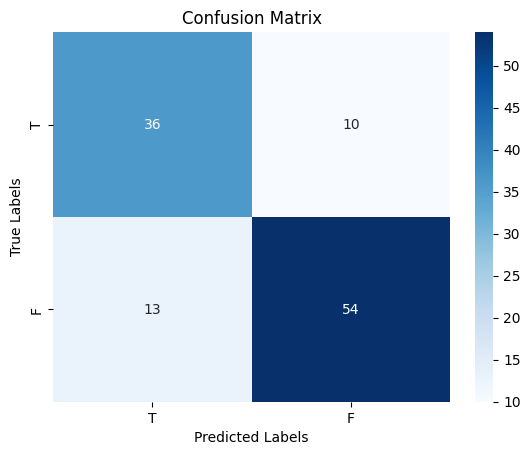

In [ ]:
# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['T', 'F'])

# Display the confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['T', 'F'], yticklabels=['T', 'F'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

3.2 Second fold

In [ ]:
# Specify the file path
excel_file_path = '/content/testing_scenario_split_2.xlsx'

# Read the Excel file into a DataFrame
df_testing_scenario_split_2 = pd.read_excel(excel_file_path)

# Display the DataFrame
df_testing_scenario_split_2.head()

,ID,Comment,Hate Speech H,sent,type,labels
0,445,"E vetmja që nuk ka idenë e dialogut në Panel, ...",NaN,"E vetmja që nuk ka idenë e dialogut në panel, ...",Politics,T
1,118,KUDRAT OSE MEQKAT E EDUIN KRISTAQ RAMAVUQIQIT ...,T,Kudrat ose meqkat e Eduin Krista Ramavuqiqit s...,Politics,F
2,31,Ekrani ka ra shum posht.. figura,NaN,"Ekrani ka rene shume poshte, figura ...",Politics,F
3,132,Pd paska dhe pederaste ne Gjermani,T,PD-ja paska dhe pederaste ne Gjermani.,Politics,T
4,141,Çfare Gomarit ky Balliu 😅,T,Çfare gomari ky Balliu!,Politics,T


In [ ]:
fine_tuned_model_id_2cv = 'ft:gpt-3.5-turbo-0125:personal:politics-split2:9HqUVVIf'
store_predictions(df_testing_scenario_split_2, fine_tuned_model_id_2cv)

In [ ]:
predictions_2cv_df = pd.read_csv("predictions.csv")

In [ ]:
true_labels = predictions_2cv_df['labels']
predicted_labels = predictions_2cv_df['Prediction']

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"Precision: {precision:.4f}")

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"Recall: {recall:.4f}")

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.7345
Precision: 0.6735
Recall: 0.7021
F1 Score: 0.6875


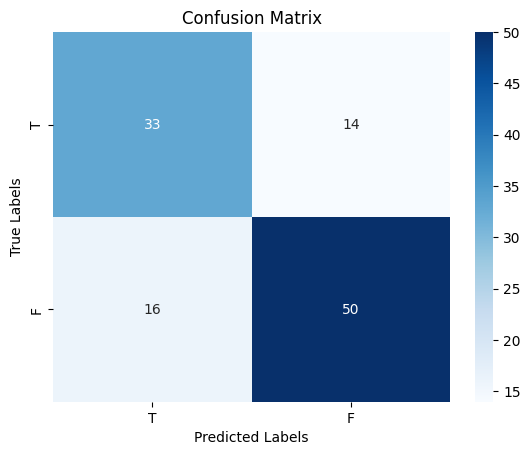

In [ ]:
# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['T', 'F'])

# Display the confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['T', 'F'], yticklabels=['T', 'F'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

3.3 Third fold

In [ ]:
# Specify the file path
excel_file_path = '/content/testing_scenario_split_3.xlsx'

# Read the Excel file into a DataFrame
df_testing_scenario_split_3 = pd.read_excel(excel_file_path)
df_testing_scenario_split_3['labels'] = df_testing_scenario_split_3['labels'].replace({True: 'T', False: 'F'})
# Display the DataFrame
df_testing_scenario_split_3.head()

,ID,Comment,Hate Speech H,sent,type,labels
0,408,VETEM NE TIRANE GJETI BLINKEN FOTOGRAFINE...,F,VETEM NE TIRANE GJETI BLINKEN FOTOGRAFINE...,Politics,F
1,448,Investimi ne drejtesi eshte nje deshtim i plot...,F,Investimi ne drejtesi eshte nje deshtim i plot...,Politics,F
2,269,"Popull hypokrite shqiptaret, te Pa afte per te...",T,"Popull hipokrit, shqiptaret! Te paafte per te ...",Politics,T
3,71,America interesat e veta humbje nga Russia,F,"Amerika interesat e veta, humbje nga Rusia.",Politics,F
4,232,Do kthehemi ne nje depo rrefugjatesh qe evrop...,F,Do kthehemi ne nje depo refugjatesh qe evropa...,Politics,F


In [ ]:
fine_tuned_model_id_3_cv = 'ft:gpt-3.5-turbo-0125:personal:politics-split3:9HvSD0Xw'
store_predictions(df_testing_scenario_split_3, fine_tuned_model_id_3_cv)
predictions_3cv_df = pd.read_csv("predictions.csv")

In [ ]:
true_labels = predictions_3cv_df['labels']
predicted_labels = predictions_3cv_df['Prediction']

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"Precision: {precision:.4f}")

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"Recall: {recall:.4f}")

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.8661
Precision: 0.8163
Recall: 0.8696
F1 Score: 0.8421


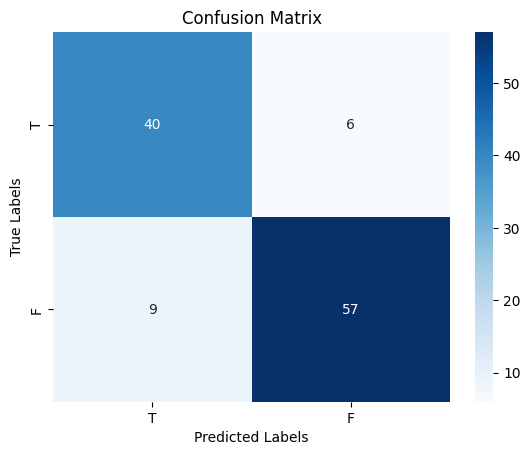

In [ ]:
# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['T', 'F'])

# Display the confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['T', 'F'], yticklabels=['T', 'F'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

3.4 Forth fold

In [ ]:
# Specify the file path
excel_file_path = '/content/testing_scenario_split_4.xlsx'

# Read the Excel file into a DataFrame
df_testing_scenario_split_4 = pd.read_excel(excel_file_path)
df_testing_scenario_split_4['labels'] = df_testing_scenario_split_4['labels'].replace({True: 'T', False: 'F'})

# Display the DataFrame
df_testing_scenario_split_4.head()

,ID,Comment,Hate Speech H,sent,type,labels
0,298,5th fleet on the move. Albania will have per ...,F,5th fleet on the move. Albania will have per ...,Politics,F
1,125,Per respek si nuk keni turp qe folni o serb,NaN,"Per respekt, si nuk keni turp qe flisni o Serb?",Politics,F
2,79,Mbetjet osmane!!! Wtf,NaN,Mbetjet Osmane!!! Wtf,Politics,F
3,424,Blinken cfar tha per Cekun e Bardh🤔,F,Blinken cfare tha per cekun e bardhe?!🤔,Politics,F
4,287,kurd seherbazi nga vlladimiri tradhtari shkerd...,T,"Kurd seherbazi nga Vlladimiri ,tradhtari, shke...",Politics,T


In [ ]:
fine_tuned_model_id_4cv = 'ft:gpt-3.5-turbo-0125:personal:politics-split4:9HwjSHqo'
store_predictions(df_testing_scenario_split_4, fine_tuned_model_id_4cv)
predictions_4cv_df = pd.read_csv("predictions.csv")

In [ ]:
true_labels = predictions_4cv_df['labels']
predicted_labels = predictions_4cv_df['Prediction']

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"Precision: {precision:.4f}")

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"Recall: {recall:.4f}")

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.8929
Precision: 0.8696
Recall: 0.8696
F1 Score: 0.8696


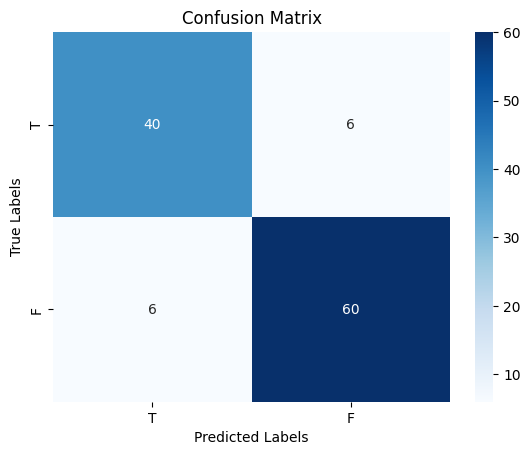

In [ ]:
# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['T', 'F'])

# Display the confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['T', 'F'], yticklabels=['T', 'F'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

3.5 Overall Metrics

In [ ]:
# Accuracy values
accuracy_values = [0.8816, 0.8512, 0.8688, 0.8624]

# average and standard deviation
average_accuracy = np.mean(accuracy_values)
std_dev_accuracy = np.std(accuracy_values)

# Print the results
print(f"Average Accuracy: {average_accuracy:.4f}")
print(f"Standard Deviation of Accuracy: {std_dev_accuracy:.4f}")

Average Accuracy: 0.8660
Standard Deviation of Accuracy: 0.0110


## 4. Original Comments Model Results


4.1 First fold

In [ ]:
# Specify the file path
excel_file_path = '/content/testing_scenario_split_1.xlsx'

# Read the Excel file into a DataFrame
df_testing_scenario_split_1 = pd.read_excel(excel_file_path)

# Display the DataFrame
df_testing_scenario_split_1.head()

,ID,sent,Hate Speech H,Grammatically corrected comment,type,labels
0,416,Lubonja kapet pse kaq shume police e siguri pe...,F,Lubonja kapet: pse kaq shume police e siguri p...,Politics,T
1,158,Rama ka 500 difekte por ësht i vetmi që ka top...,NaN,"Rama ka 500 difekte, por ështe i vetmi që ka k...",Politics,F
2,326,Vetem Dashi flet si duhet bravo,F,Vetem Dashi flet si duhet bravo!,Politics,F
3,431,Si nuk foli per ate te ballkoni?😢😢😢,F,Si nuk foli per ate te ballkoni?😢😢😢,Politics,F
4,77,KY legeni I Gjermanise dergoje per te pire nje...,T,Ketij legenit te Gjermanise dergoji per te pir...,Politics,T


In [ ]:
fine_tuned_model_id = 'ft:gpt-3.5-turbo-0125:personal:originalpo-split1:9Hs5ptbm'

store_predictions(df_testing_scenario_split_1, fine_tuned_model_id)

predictions_df = pd.read_csv("predictions.csv")


In [ ]:
true_labels = predictions_df['labels']
predicted_labels = predictions_df['Prediction']

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"Precision: {precision:.4f}")

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"Recall: {recall:.4f}")

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.7434
Precision: 0.6809
Recall: 0.6957
F1 Score: 0.6882


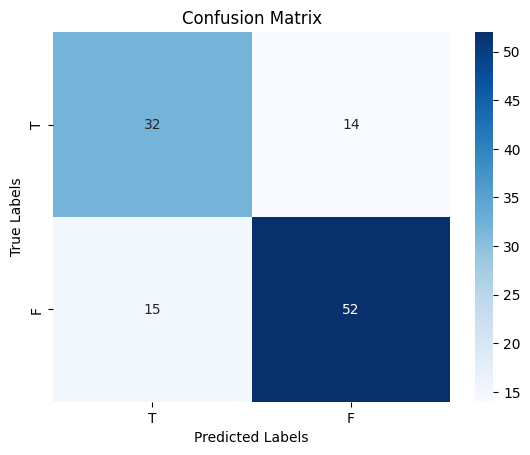

In [ ]:
# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['T', 'F'])

# Display the confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['T', 'F'], yticklabels=['T', 'F'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

4.2 Second fold


In [ ]:
# Specify the file path
excel_file_path = '/content/testing_scenario_split_2.xlsx'

# Read the Excel file into a DataFrame
df_testing_scenario_split_2 = pd.read_excel(excel_file_path)

# Display the DataFrame
df_testing_scenario_split_2.head()

,ID,sent,Hate Speech H,Grammatically corrected comment,type,labels
0,445,"E vetmja që nuk ka idenë e dialogut në Panel, ...",NaN,"E vetmja që nuk ka idenë e dialogut në panel, ...",Politics,T
1,118,KUDRAT OSE MEQKAT E EDUIN KRISTAQ RAMAVUQIQIT ...,T,Kudrat ose meqkat e Eduin Krista Ramavuqiqit s...,Politics,F
2,31,Ekrani ka ra shum posht.. figura,NaN,"Ekrani ka rene shume poshte, figura ...",Politics,F
3,132,Pd paska dhe pederaste ne Gjermani,T,PD-ja paska dhe pederaste ne Gjermani.,Politics,T
4,141,Çfare Gomarit ky Balliu 😅,T,Çfare gomari ky Balliu!,Politics,T


In [ ]:
fine_tuned_model_id = 'ft:gpt-3.5-turbo-0125:personal:originalpo-split2:9Hsjxepy'

store_predictions(df_testing_scenario_split_2, fine_tuned_model_id)

predictions_df = pd.read_csv("predictions.csv")

In [ ]:
true_labels = predictions_df['labels']
predicted_labels = predictions_df['Prediction']

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"Precision: {precision:.4f}")

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"Recall: {recall:.4f}")

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.7699
Precision: 0.7234
Recall: 0.7234
F1 Score: 0.7234


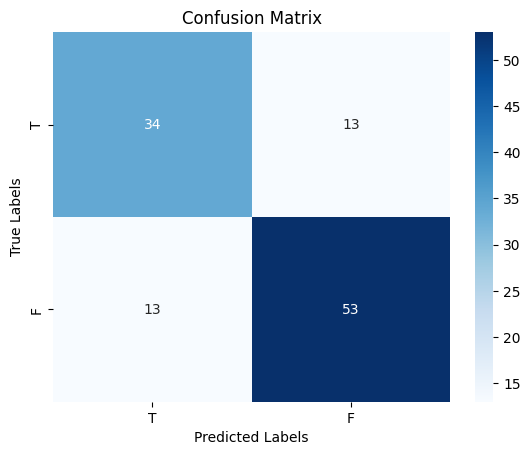

In [ ]:
# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['T', 'F'])

# Display the confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['T', 'F'], yticklabels=['T', 'F'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

4.3 Third Fold

In [ ]:
# Specify the file path
excel_file_path = '/content/testing_scenario_split_3.xlsx'

# Read the Excel file into a DataFrame
df_testing_scenario_split_3 = pd.read_excel(excel_file_path)

# Display the DataFrame
df_testing_scenario_split_3.head()

,ID,sent,Hate Speech H,Grammatically corrected comment,type,labels
0,408,VETEM NE TIRANE GJETI BLINKEN FOTOGRAFINE...,F,VETEM NE TIRANE GJETI BLINKEN FOTOGRAFINE...,Politics,F
1,448,Investimi ne drejtesi eshte nje deshtim i plot...,F,Investimi ne drejtesi eshte nje deshtim i plot...,Politics,F
2,269,"Popull hypokrite shqiptaret, te Pa afte per te...",T,"Popull hipokrit, shqiptaret! Te paafte per te ...",Politics,T
3,71,America interesat e veta humbje nga Russia,F,"Amerika interesat e veta, humbje nga Rusia.",Politics,F
4,232,Do kthehemi ne nje depo rrefugjatesh qe evrop...,F,Do kthehemi ne nje depo refugjatesh qe evropa...,Politics,F


In [ ]:
fine_tuned_model_id = 'ft:gpt-3.5-turbo-0125:personal:originalpo-split3:9HtxO7vn'

store_predictions(df_testing_scenario_split_3, fine_tuned_model_id)

predictions_df = pd.read_csv("predictions.csv")

In [ ]:
true_labels = predictions_df['labels']
predicted_labels = predictions_df['Prediction']

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"Precision: {precision:.4f}")

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"Recall: {recall:.4f}")

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.7857
Precision: 0.6897
Recall: 0.8696
F1 Score: 0.7692


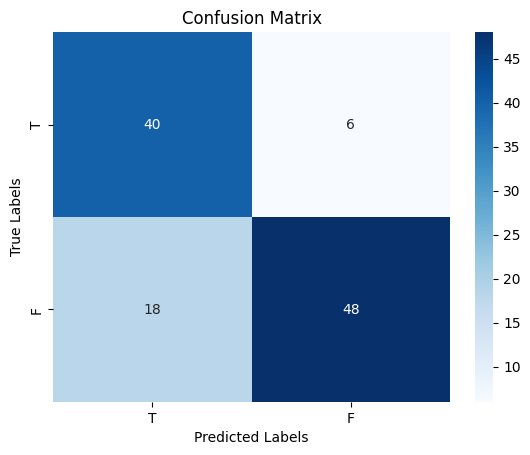

In [ ]:
# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['T', 'F'])

# Display the confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['T', 'F'], yticklabels=['T', 'F'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

4.4 Forth Fold

In [ ]:
# Specify the file path
excel_file_path = '/content/testing_scenario_split_4.xlsx'

# Read the Excel file into a DataFrame
df_testing_scenario_split_4 = pd.read_excel(excel_file_path)

# Display the DataFrame
df_testing_scenario_split_4.head()

,ID,sent,Hate Speech H,Grammatically corrected comment,type,labels
0,298,5th fleet on the move. Albania will have per ...,F,5th fleet on the move. Albania will have per ...,Politics,F
1,125,Per respek si nuk keni turp qe folni o serb,NaN,"Per respekt, si nuk keni turp qe flisni o Serb?",Politics,F
2,79,Mbetjet osmane!!! Wtf,NaN,Mbetjet Osmane!!! Wtf,Politics,F
3,424,Blinken cfar tha per Cekun e Bardh🤔,F,Blinken cfare tha per cekun e bardhe?!🤔,Politics,F
4,287,kurd seherbazi nga vlladimiri tradhtari shkerd...,T,"Kurd seherbazi nga Vlladimiri ,tradhtari, shke...",Politics,T


In [ ]:
fine_tuned_model_id = 'ft:gpt-3.5-turbo-0125:personal:originalpo-split4:9HuVmxkT'

store_predictions(df_testing_scenario_split_4, fine_tuned_model_id)

predictions_df = pd.read_csv("predictions.csv")

In [ ]:
true_labels = predictions_df['labels']
predicted_labels = predictions_df['Prediction']

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"Precision: {precision:.4f}")

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"Recall: {recall:.4f}")

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8304
Precision: 0.7755
Recall: 0.8261
F1 Score: 0.8000


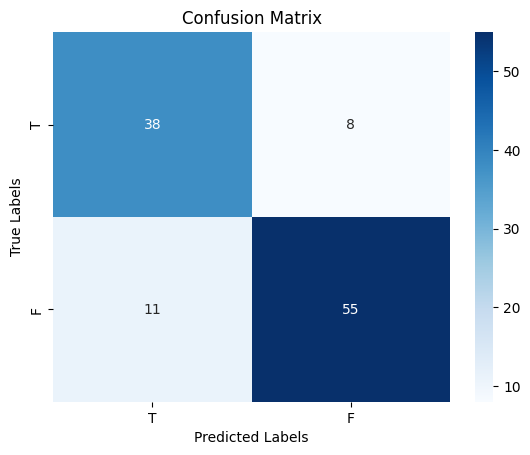

In [ ]:
# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['T', 'F'])

# Display the confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['T', 'F'], yticklabels=['T', 'F'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

4.5 Overall Metrics

In [ ]:
# Accuracy values
accuracy_values = [0.7434, 0.7699, 0.7857, 0.8304]

# average and standard deviation
average_accuracy = np.mean(accuracy_values)
std_dev_accuracy = np.std(accuracy_values)

# Print the results
print(f"Average Accuracy: {average_accuracy:.4f}")
print(f"Standard Deviation of Accuracy: {std_dev_accuracy:.4f}")

Average Accuracy: 0.7823
Standard Deviation of Accuracy: 0.0316


## 5 Analysis of results


5.1 ROC curve (worst and best model)

In [6]:
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
predictions_df = pd.read_csv("predictions_split1.csv")
y_true = predictions_df['labels']
y_pred = predictions_df['Prediction']

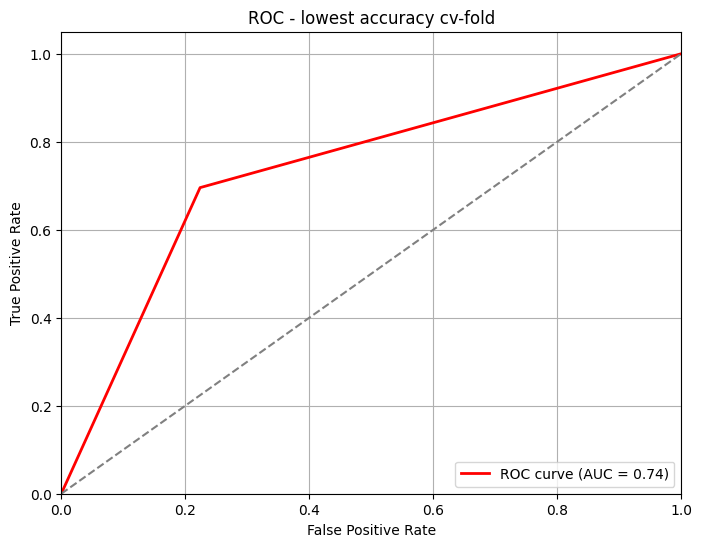

In [ ]:
y_true_binary = np.where(y_true == 'T', 1, 0)
y_pred_binary = np.where(y_pred == 'T', 1, 0)
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred_binary)

# Calculate the area under the ROC curve
roc_auc = roc_auc_score(y_true_binary, y_pred_binary)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - lowest accuracy cv-fold')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
predictions_df = pd.read_csv("predictions_split2.csv")
y_true = predictions_df['labels']
y_pred = predictions_df['Prediction']

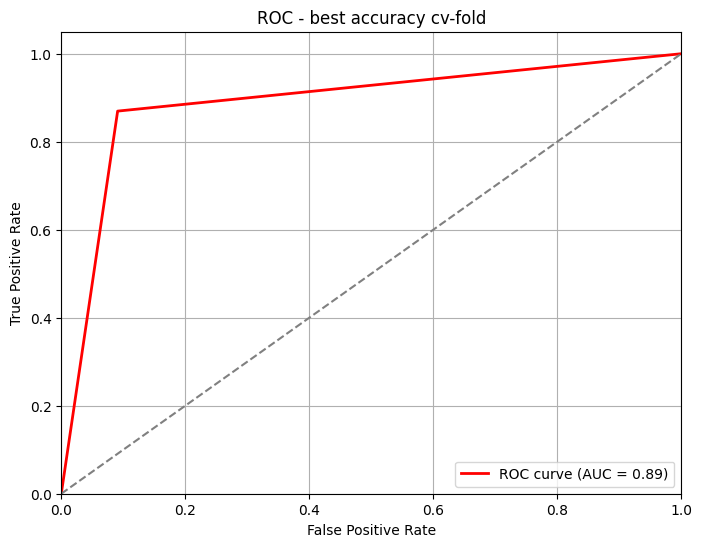

In [ ]:
y_true_binary = np.where(y_true == 'T', 1, 0)
y_pred_binary = np.where(y_pred == 'T', 1, 0)
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred_binary)

# Calculate the area under the ROC curve
roc_auc = roc_auc_score(y_true_binary, y_pred_binary)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - best accuracy cv-fold')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

5.2 Linguistic analysis of FP and FN


In [ ]:
# 2 fold-cv of Corrected comments
df = pd.read_csv("/content/predictions_split2.csv")

In [ ]:
# Filter false positives
false_positives_df = df[(df['labels'] == 'F') & (df['Prediction'] == 'T')]

# Filter false negatives
false_negatives_df = df[(df['labels'] == 'T') & (df['Prediction'] == 'F')]


In [ ]:
false_negatives_df

,Unnamed: 0,ID,Comment,Hate Speech H,sent,type,labels,Prediction
0,0,445,"E vetmja që nuk ka idenë e dialogut në Panel, ...",NaN,"E vetmja që nuk ka idenë e dialogut në panel, ...",Politics,T,F
9,9,397,Lubonja si opozitar ha makarona ne Itali pasta...,NaN,Lubonja si opozitar ha makarona ne Itali pasta...,Politics,T,F
15,15,73,PD eshte hale,T,PD eshte hale.,Politics,T,F
17,17,356,"Te besh analize eshte gjeja me e thjeshte, bol...",T,"Te besh analize eshte gjeja me e thjeshte, bol...",Politics,T,F
22,22,83,Juve I bini qemaneve si te doni. E vertebra es...,T,Juve i bini qemaneve si te doni. E verteta esh...,Politics,T,F
27,27,43,Turp te kesh ti si drejtus qe ben komand nje d...,T,"Turp te kesh ti si drejtues qe ben komande, nj...",Politics,T,F
38,38,249,Cfar eshte ai klloun cirku deputet??😢😢😢,NaN,Cfare eshte ai kloun cirku deputet??😢😢😢,Politics,T,F
39,39,375,Qipa eshte bere me gojore se ky permutari,NaN,Qipa eshte bere me gojore se ky permutari,Politics,T,F
63,63,124,Balliu rend fare\nNeshon per cfare e therrisni...,NaN,Balliu rende fare!\nNeshon per cfare e therris...,Politics,T,F
66,66,38,Kush je TI more zotni,F,Kush je ti more zoteri?,Politics,T,F


In [7]:
pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.7 MB/s eta 0:00:00


In [8]:
import tiktoken

encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
print("Encoding model used:",encoding)


Encoding model used: <Encoding 'cl100k_base'>


In [9]:
def compare_encodings(example_string: str) -> None:
    """Prints a comparison of three string encodings."""
    # print the example string
    print(f'\nExample string: "{example_string}"')
    # for each encoding, print the # of tokens, the token integers, and the token bytes
    for encoding_name in ["cl100k_base"]:
        encoding = tiktoken.get_encoding(encoding_name)
        token_integers = encoding.encode(example_string)
        num_tokens = len(token_integers)
        token_bytes = [encoding.decode_single_token_bytes(token) for token in token_integers]
        print()
        print(f"{encoding_name}: {num_tokens} tokens")
        print(f"token integers: {token_integers}")
        print(f"token bytes: {token_bytes}")


In [10]:
compare_encodings("Moj, Xhulalja ne SPAK, maloku Sali Berisha ka me shume se 5 prokurore spiune te tij te fshehte personale qe sherbimet e dine, moj maloke diplomatike e Sali Berishes.")


Example string: "Moj, Xhulalja ne SPAK, maloku Sali Berisha ka me shume se 5 prokurore spiune te tij te fshehte personale qe sherbimet e dine, moj maloke diplomatike e Sali Berishes."

cl100k_base: 60 tokens
token integers: [44, 21963, 11, 1630, 71, 360, 278, 5697, 841, 77508, 42, 11, 8811, 16900, 328, 8115, 9084, 36040, 16909, 757, 559, 3972, 513, 220, 20, 463, 74, 2868, 265, 28047, 2957, 1028, 259, 3251, 1028, 8789, 383, 56599, 1732, 1604, 2874, 68, 35313, 65, 86366, 384, 66207, 11, 4647, 73, 8811, 4845, 69050, 3043, 384, 328, 8115, 9084, 21168, 13]
token bytes: [b'M', b'oj', b',', b' X', b'h', b'ul', b'al', b'ja', b' ne', b' SPA', b'K', b',', b' mal', b'oku', b' S', b'ali', b' Ber', b'isha', b' ka', b' me', b' sh', b'ume', b' se', b' ', b'5', b' pro', b'k', b'uro', b're', b' spi', b'une', b' te', b' t', b'ij', b' te', b' fs', b'he', b'hte', b' person', b'ale', b' q', b'e', b' sher', b'b', b'imet', b' e', b' dine', b',', b' mo', b'j', b' mal', b'oke', b' diplomat', b'ike', b' e', b'

In [11]:
compare_encodings("MOJ XHULALJA NE SPAKE MALOKU SALI BERISHA KA ME SHUME SE 5 PROKURORE SPIUNE TE TIJE TE FSHEHTE PERSNALE QE SHERBIMET E DINE MOJ MALOKE DIPLOMATE E SALI BERSHURES")


Example string: "MOJ XHULALJA NE SPAKE MALOKU SALI BERISHA KA ME SHUME SE 5 PROKURORE SPIUNE TE TIJE TE FSHEHTE PERSNALE QE SHERBIMET E DINE MOJ MALOKE DIPLOMATE E SALI BERSHURES"

cl100k_base: 70 tokens
token integers: [10754, 41, 1630, 39, 1112, 984, 45280, 8014, 77508, 3472, 89139, 4012, 52, 54209, 40, 94674, 16849, 32, 90078, 16691, 6570, 34993, 5161, 220, 20, 5421, 42, 52, 1308, 793, 21061, 50489, 18793, 39237, 41429, 18793, 25275, 1837, 39, 2505, 393, 4419, 7476, 877, 100116, 328, 3087, 33, 1829, 1372, 469, 423, 4069, 11672, 41, 89139, 46, 3472, 423, 3378, 1623, 44, 2390, 469, 54209, 40, 426, 4419, 39, 51761]
token bytes: [b'MO', b'J', b' X', b'H', b'UL', b'AL', b'JA', b' NE', b' SPA', b'KE', b' MAL', b'OK', b'U', b' SAL', b'I', b' BER', b'ISH', b'A', b' KA', b' ME', b' SH', b'UME', b' SE', b' ', b'5', b' PRO', b'K', b'U', b'RO', b'RE', b' SPI', b'UNE', b' TE', b' TI', b'JE', b' TE', b' FS', b'HE', b'H', b'TE', b' P', b'ERS', b'NA', b'LE', b' QE', b' S', b'HER', b'B', b'IM', b'E

In [12]:
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

print("Encoding of original word",encoding.encode("MALOKU")) # MAL OK U

print("Encoding of corrected word",encoding.encode("maloku")) # mal oku


Encoding of original word [89899, 4012, 52]
Encoding of corrected word [14991, 16900]


In [ ]:
compare_encodings("Love z Lubonja♥️♥️♥️ Intelektual, origjinal, me kurajo civile, Hila nje intelektual provincial qe I pelqen vetja🤮")


Example string: "Love z Lubonja♥️♥️♥️ Intelektual, origjinal, me kurajo civile, Hila nje intelektual provincial qe I pelqen vetja🤮"

cl100k_base: 46 tokens
token integers: [29351, 1167, 58751, 263, 5697, 77809, 31643, 77809, 31643, 77809, 31643, 1357, 10274, 5964, 940, 11, 2780, 73, 992, 11, 757, 28364, 19256, 18969, 458, 11, 473, 10746, 308, 3841, 528, 10274, 5964, 940, 36031, 2874, 68, 358, 12077, 80, 268, 24195, 5697, 9468, 97, 106]
token bytes: [b'Love', b' z', b' Lub', b'on', b'ja', b'\xe2\x99\xa5', b'\xef\xb8\x8f', b'\xe2\x99\xa5', b'\xef\xb8\x8f', b'\xe2\x99\xa5', b'\xef\xb8\x8f', b' Int', b'ele', b'kt', b'ual', b',', b' orig', b'j', b'inal', b',', b' me', b' kur', b'ajo', b' civ', b'ile', b',', b' H', b'ila', b' n', b'je', b' int', b'ele', b'kt', b'ual', b' provincial', b' q', b'e', b' I', b' pel', b'q', b'en', b' vet', b'ja', b'\xf0\x9f', b'\xa4', b'\xae']


In [ ]:
compare_encodings("Love z Lubonja♥️♥️♥️ Intelektual, origjinal, me kurajo civile, Hila nje intelektual provincial qe i pelqen vetja🤮")


Example string: "Love z Lubonja♥️♥️♥️ Intelektual, origjinal, me kurajo civile, Hila nje intelektual provincial qe i pelqen vetja🤮"

cl100k_base: 46 tokens
token integers: [29351, 1167, 58751, 263, 5697, 77809, 31643, 77809, 31643, 77809, 31643, 1357, 10274, 5964, 940, 11, 2780, 73, 992, 11, 757, 28364, 19256, 18969, 458, 11, 473, 10746, 308, 3841, 528, 10274, 5964, 940, 36031, 2874, 68, 602, 12077, 80, 268, 24195, 5697, 9468, 97, 106]
token bytes: [b'Love', b' z', b' Lub', b'on', b'ja', b'\xe2\x99\xa5', b'\xef\xb8\x8f', b'\xe2\x99\xa5', b'\xef\xb8\x8f', b'\xe2\x99\xa5', b'\xef\xb8\x8f', b' Int', b'ele', b'kt', b'ual', b',', b' orig', b'j', b'inal', b',', b' me', b' kur', b'ajo', b' civ', b'ile', b',', b' H', b'ila', b' n', b'je', b' int', b'ele', b'kt', b'ual', b' provincial', b' q', b'e', b' i', b' pel', b'q', b'en', b' vet', b'ja', b'\xf0\x9f', b'\xa4', b'\xae']


## 6. Results of Models for all topics

# 6.1 First Fold

In [9]:
# Specify the file path
excel_file_path = '/content/testing_scenario_split_1.xlsx'

# Read the Excel file into a DataFrame
df_testing_scenario_split_1 = pd.read_excel(excel_file_path)

# Display the DataFrame
df_testing_scenario_split_1.head()

,ID,Comment,sent,type,labels
0,1126,Ah Enver Hoxha ku je ?,"Ah Enver Hoxha, ku je ?",Actuality,F
1,50,Vllezrit tan kinezet ruset sot amerikanet pun ...,"\nVellezerit tane kinezet, rusët, sot jane ame...",Politics,T
2,395,Lubonja cfar meresh me legenat e Rames ato han...,"Lubonja cfare meresh me legenat e Rames, ato h...",Politics,T
3,260,Ngjela po na del byth lepirs i Rames,Ngjela po na del bythlepires i Rames.,Politics,T
4,783,Enisa je një super legen femër ooo 🐖🐷🐷🐖🐖🐖 iqen...,Enisa je një super legen femër ooo 🐖🐷🐷🐖🐖🐖 hiqe...,Dating show,T


In [10]:
fine_tuned_model_id = 'ft:gpt-3.5-turbo-0125:personal:allsplit1:9KjpCdpH'
store_predictions(df_testing_scenario_split_1, fine_tuned_model_id)
predictions_df = pd.read_csv("predictions.csv")

In [11]:

true_labels = predictions_df['labels']
predicted_labels = predictions_df['Prediction']

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"Precision: {precision:.4f}")

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"Recall: {recall:.4f}")

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.8264
Precision: 0.7812
Recall: 0.8170
F1 Score: 0.7987


In [14]:
# Get unique categories from the 'type' column
categories = predictions_df['type'].unique()

# Initialize dictionaries to store metrics for each category
accuracy_dict = {}
precision_dict = {}
recall_dict = {}
f1_dict = {}

# Calculate metrics for each category
for category in categories:
    category_indices = predictions_df['type'] == category
    category_true_labels = true_labels[category_indices]
    category_predicted_labels = predicted_labels[category_indices]

    # Calculate accuracy
    accuracy = accuracy_score(category_true_labels, category_predicted_labels)
    accuracy_dict[category] = accuracy

    # Calculate precision
    precision = precision_score(category_true_labels, category_predicted_labels, average='binary', pos_label='T')
    precision_dict[category] = precision

    # Calculate recall
    recall = recall_score(category_true_labels, category_predicted_labels, average='binary',pos_label='T')
    recall_dict[category] = recall

    # Calculate F1 score
    f1 = f1_score(category_true_labels, category_predicted_labels, average='binary', pos_label='T')
    f1_dict[category] = f1

# Print metrics for each category
for category in categories:
    print(f"Category: {category}")
    print(f"Accuracy: {accuracy_dict[category]:.4f}")
    print(f"Precision: {precision_dict[category]:.4f}")
    print(f"Recall: {recall_dict[category]:.4f}")
    print(f"F1 Score: {f1_dict[category]:.4f}")
    print()

Category: Actuality
Accuracy: 0.7863
Precision: 0.7222
Recall: 0.7500
F1 Score: 0.7358

Category: Politics
Accuracy: 0.8889
Precision: 0.9091
Recall: 0.8163
F1 Score: 0.8602

Category: Dating show
Accuracy: 0.8087
Precision: 0.7419
Recall: 0.8846
F1 Score: 0.8070



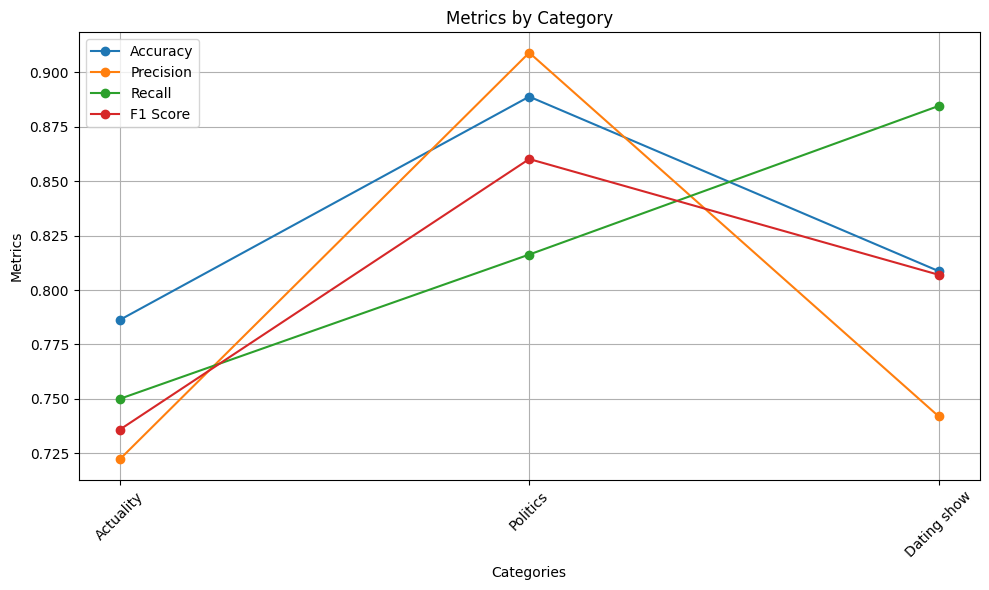

In [32]:

# Load the CSV file into a DataFrame
predictions_df = pd.read_csv("predictions.csv")

# Replace 'f' with 'F' in the 'labels' column
predictions_df['labels'] = predictions_df['labels'].replace('f', 'F')

# Get unique categories from the 'type' column
categories = predictions_df['type'].unique()

# Initialize dictionaries to store metrics for each category
accuracy_dict = {}
precision_dict = {}
recall_dict = {}
f1_dict = {}

# Calculate metrics for each category
for category in categories:
    category_indices = predictions_df['type'] == category
    category_true_labels = predictions_df[category_indices]['labels']
    category_predicted_labels = predictions_df[category_indices]['Prediction']

    # Calculate accuracy
    accuracy = accuracy_score(category_true_labels, category_predicted_labels)
    accuracy_dict[category] = accuracy

    # Calculate precision
    precision = precision_score(category_true_labels, category_predicted_labels, pos_label='T')
    precision_dict[category] = precision

    # Calculate recall
    recall = recall_score(category_true_labels, category_predicted_labels, pos_label='T')
    recall_dict[category] = recall

    # Calculate F1 score
    f1 = f1_score(category_true_labels, category_predicted_labels, pos_label='T')
    f1_dict[category] = f1

# Create a line chart
fig, ax = plt.subplots(figsize=(10, 6))

index = range(len(categories))

ax.plot(categories, accuracy_dict.values(), marker='o', label='Accuracy')
ax.plot(categories, precision_dict.values(), marker='o', label='Precision')
ax.plot(categories, recall_dict.values(), marker='o', label='Recall')
ax.plot(categories, f1_dict.values(), marker='o', label='F1 Score')

ax.set_xlabel('Categories')
ax.set_ylabel('Metrics')
ax.set_title('Metrics by Category')
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

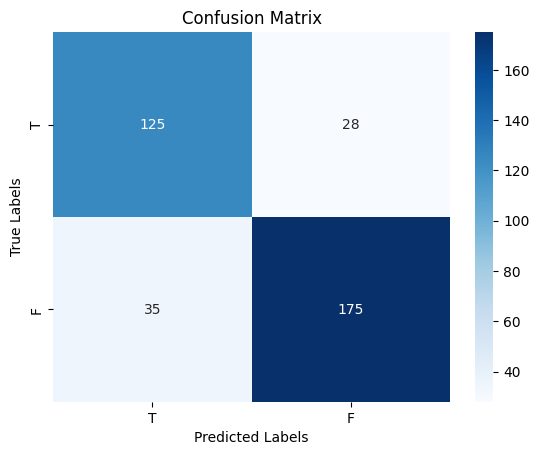

In [12]:
# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['T', 'F'])

# Display the confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['T', 'F'], yticklabels=['T', 'F'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 6.2 Second fold


In [15]:
# Specify the file path
excel_file_path = '/content/testing_scenario_split_2.xlsx'

# Read the Excel file into a DataFrame
df_testing_scenario_split_2 = pd.read_excel(excel_file_path)

# Display the DataFrame
df_testing_scenario_split_2.head()

,ID,Comment,sent,type,labels
0,1038,11:28 kjo eshte debile komplet. Sa shume i nga...,11:28 kjo eshte debile komplet. Sa shume i nga...,Actuality,T
1,1318,Nuk eshte e mir kjo qe ka ba por duhet gjyku e...,"Nuk eshte e mire kjo qe ka bere, por duhen gjy...",Actuality,F
2,666,Fillimisht neda gjykoj mire pastaj me vone e u...,"Fillimisht, Neda gjykoj mire, pastaj me vone e...",Dating show,T
3,877,Car esht kafe apo program televiziv nuk kam pa...,Cfare eshte kafe apo program televiziv? Nuk ka...,Dating show,F
4,275,Pse po rren mashtrus,"Pse po genjen, mashtrues?",Politics,F


In [16]:
fine_tuned_model_id = 'ft:gpt-3.5-turbo-0125:personal:allsplit2:9Km2Do7v'
store_predictions(df_testing_scenario_split_2, fine_tuned_model_id)
predictions_df = pd.read_csv("predictions.csv")

In [17]:
true_labels = predictions_df['labels']
predicted_labels = predictions_df['Prediction']

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"Precision: {precision:.4f}")

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"Recall: {recall:.4f}")

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.8457
Precision: 0.7927
Recall: 0.8553
F1 Score: 0.8228


In [18]:
# Get unique categories from the 'type' column
categories = predictions_df['type'].unique()

# Initialize dictionaries to store metrics for each category
accuracy_dict = {}
precision_dict = {}
recall_dict = {}
f1_dict = {}

# Calculate metrics for each category
for category in categories:
    category_indices = predictions_df['type'] == category
    category_true_labels = true_labels[category_indices]
    category_predicted_labels = predicted_labels[category_indices]

    # Calculate accuracy
    accuracy = accuracy_score(category_true_labels, category_predicted_labels)
    accuracy_dict[category] = accuracy

    # Calculate precision
    precision = precision_score(category_true_labels, category_predicted_labels, average='binary', pos_label='T')
    precision_dict[category] = precision

    # Calculate recall
    recall = recall_score(category_true_labels, category_predicted_labels, average='binary',pos_label='T')
    recall_dict[category] = recall

    # Calculate F1 score
    f1 = f1_score(category_true_labels, category_predicted_labels, average='binary', pos_label='T')
    f1_dict[category] = f1

# Print metrics for each category
for category in categories:
    print(f"Category: {category}")
    print(f"Accuracy: {accuracy_dict[category]:.4f}")
    print(f"Precision: {precision_dict[category]:.4f}")
    print(f"Recall: {recall_dict[category]:.4f}")
    print(f"F1 Score: {f1_dict[category]:.4f}")
    print()

Category: Actuality
Accuracy: 0.8601
Precision: 0.7547
Recall: 0.8511
F1 Score: 0.8000

Category: Dating show
Accuracy: 0.8235
Precision: 0.7969
Recall: 0.8644
F1 Score: 0.8293

Category: Politics
Accuracy: 0.8515
Precision: 0.8298
Recall: 0.8478
F1 Score: 0.8387



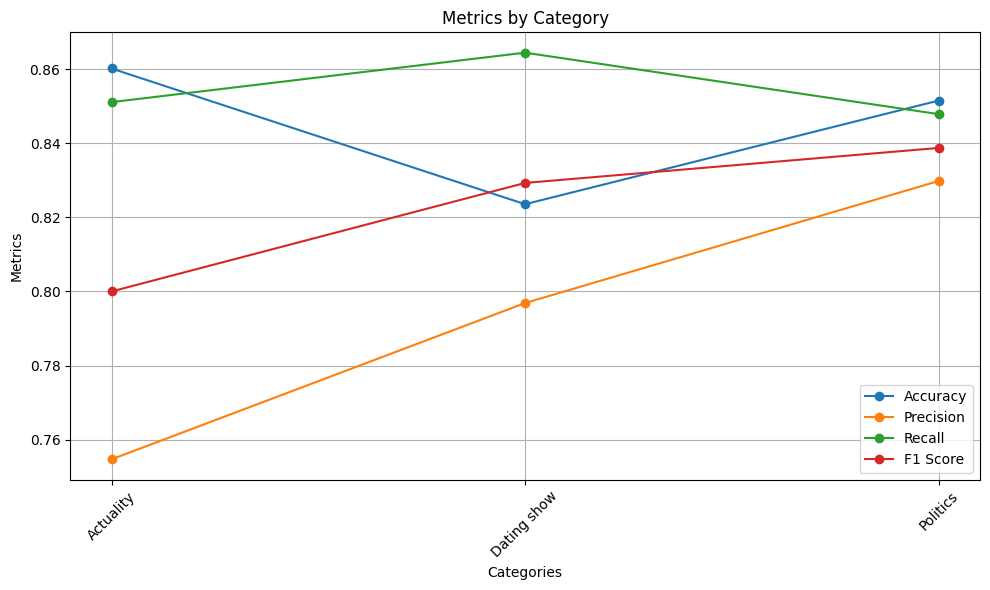

In [31]:

# Load the CSV file into a DataFrame
predictions_df = pd.read_csv("predictions.csv")

# Replace 'f' with 'F' in the 'labels' column
predictions_df['labels'] = predictions_df['labels'].replace('f', 'F')

# Get unique categories from the 'type' column
categories = predictions_df['type'].unique()

# Initialize dictionaries to store metrics for each category
accuracy_dict = {}
precision_dict = {}
recall_dict = {}
f1_dict = {}

# Calculate metrics for each category
for category in categories:
    category_indices = predictions_df['type'] == category
    category_true_labels = predictions_df[category_indices]['labels']
    category_predicted_labels = predictions_df[category_indices]['Prediction']

    # Calculate accuracy
    accuracy = accuracy_score(category_true_labels, category_predicted_labels)
    accuracy_dict[category] = accuracy

    # Calculate precision
    precision = precision_score(category_true_labels, category_predicted_labels, pos_label='T')
    precision_dict[category] = precision

    # Calculate recall
    recall = recall_score(category_true_labels, category_predicted_labels, pos_label='T')
    recall_dict[category] = recall

    # Calculate F1 score
    f1 = f1_score(category_true_labels, category_predicted_labels, pos_label='T')
    f1_dict[category] = f1

# Create a line chart
fig, ax = plt.subplots(figsize=(10, 6))

index = range(len(categories))

ax.plot(categories, accuracy_dict.values(), marker='o', label='Accuracy')
ax.plot(categories, precision_dict.values(), marker='o', label='Precision')
ax.plot(categories, recall_dict.values(), marker='o', label='Recall')
ax.plot(categories, f1_dict.values(), marker='o', label='F1 Score')

ax.set_xlabel('Categories')
ax.set_ylabel('Metrics')
ax.set_title('Metrics by Category')
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


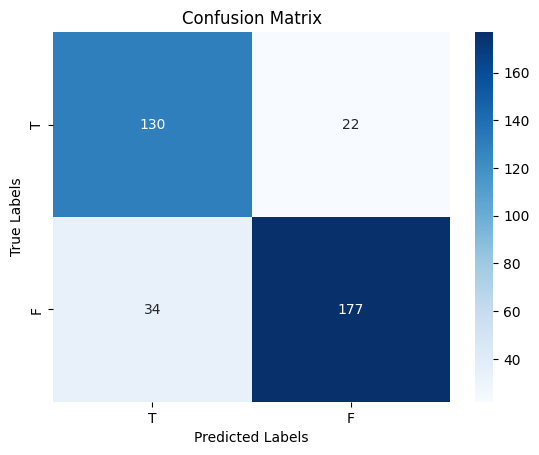

In [19]:
# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['T', 'F'])

# Display the confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['T', 'F'], yticklabels=['T', 'F'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 6.3 Third fold

In [20]:
# Specify the file path
excel_file_path = '/content/testing_scenario_split_3.xlsx'

# Read the Excel file into a DataFrame
df_testing_scenario_split_3 = pd.read_excel(excel_file_path)

# Display the DataFrame
df_testing_scenario_split_3.head()

,ID,Comment,sent,type,labels
0,999,O Akil o pseudo profesor i një pseudo shkencë ...,O Akil o pseudo profesor i një pseudo shkencë:...,Actuality,F
1,530,Enisa pfu po sje fmi moj qe as fmij nuk flet k...,"Enisa pfu, s'je femije moj, qe as femija nuk f...",Dating show,T
2,1127,"ore ju qé flisni, pér ju nuk éshté problem gru...","Ore ju qe flisni, per ju nuk eshte problem gru...",Actuality,F
3,494,Lum kush uka ne shtepi PA edukat,Lum kush u ka ne shtepi! Pa edukate!,Dating show,F
4,944,Ku je o Enver Hoxha .Kjo ashte absurde,Ku je o Enver Hoxha .Kjo ashte absurde,Actuality,F


In [21]:
fine_tuned_model_id = 'ft:gpt-3.5-turbo-0125:personal:allsplit3:9KnYiysm'
store_predictions(df_testing_scenario_split_3, fine_tuned_model_id)
predictions_df = pd.read_csv("predictions.csv")

In [22]:

true_labels = predictions_df['labels']
predicted_labels = predictions_df['Prediction']

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"Precision: {precision:.4f}")

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"Recall: {recall:.4f}")

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"F1 Score: {f1:.4f}")



Accuracy: 0.8567
Precision: 0.8425
Recall: 0.8092
F1 Score: 0.8255


In [23]:
# Get unique categories from the 'type' column
categories = predictions_df['type'].unique()

# Initialize dictionaries to store metrics for each category
accuracy_dict = {}
precision_dict = {}
recall_dict = {}
f1_dict = {}

# Calculate metrics for each category
for category in categories:
    category_indices = predictions_df['type'] == category
    category_true_labels = true_labels[category_indices]
    category_predicted_labels = predicted_labels[category_indices]

    # Calculate accuracy
    accuracy = accuracy_score(category_true_labels, category_predicted_labels)
    accuracy_dict[category] = accuracy

    # Calculate precision
    precision = precision_score(category_true_labels, category_predicted_labels, average='binary', pos_label='T')
    precision_dict[category] = precision

    # Calculate recall
    recall = recall_score(category_true_labels, category_predicted_labels, average='binary',pos_label='T')
    recall_dict[category] = recall

    # Calculate F1 score
    f1 = f1_score(category_true_labels, category_predicted_labels, average='binary', pos_label='T')
    f1_dict[category] = f1

# Print metrics for each category
for category in categories:
    print(f"Category: {category}")
    print(f"Accuracy: {accuracy_dict[category]:.4f}")
    print(f"Precision: {precision_dict[category]:.4f}")
    print(f"Recall: {recall_dict[category]:.4f}")
    print(f"F1 Score: {f1_dict[category]:.4f}")
    print()

Category: Actuality
Accuracy: 0.8385
Precision: 0.7619
Recall: 0.7442
F1 Score: 0.7529

Category: Dating show
Accuracy: 0.8167
Precision: 0.8548
Recall: 0.8030
F1 Score: 0.8281

Category: Politics
Accuracy: 0.9204
Precision: 0.9048
Recall: 0.8837
F1 Score: 0.8941



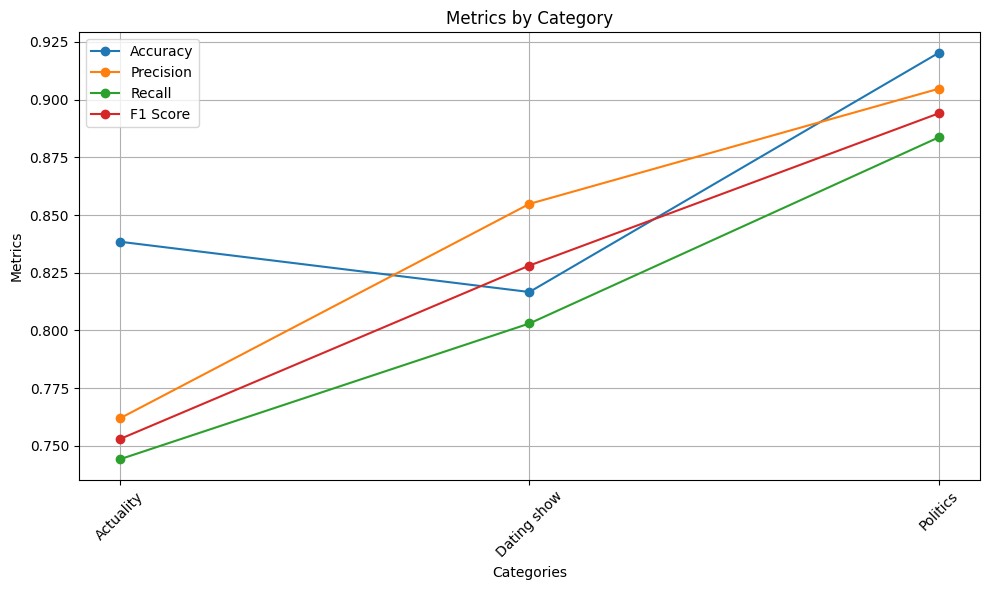

In [34]:

# Load the CSV file into a DataFrame
predictions_df = pd.read_csv("predictions.csv")

# Replace 'f' with 'F' in the 'labels' column
predictions_df['labels'] = predictions_df['labels'].replace('f', 'F')

# Get unique categories from the 'type' column
categories = predictions_df['type'].unique()

# Initialize dictionaries to store metrics for each category
accuracy_dict = {}
precision_dict = {}
recall_dict = {}
f1_dict = {}

# Calculate metrics for each category
for category in categories:
    category_indices = predictions_df['type'] == category
    category_true_labels = predictions_df[category_indices]['labels']
    category_predicted_labels = predictions_df[category_indices]['Prediction']

    # Calculate accuracy
    accuracy = accuracy_score(category_true_labels, category_predicted_labels)
    accuracy_dict[category] = accuracy

    # Calculate precision
    precision = precision_score(category_true_labels, category_predicted_labels, pos_label='T')
    precision_dict[category] = precision

    # Calculate recall
    recall = recall_score(category_true_labels, category_predicted_labels, pos_label='T')
    recall_dict[category] = recall

    # Calculate F1 score
    f1 = f1_score(category_true_labels, category_predicted_labels, pos_label='T')
    f1_dict[category] = f1

# Create a line chart
fig, ax = plt.subplots(figsize=(10, 6))

index = range(len(categories))

ax.plot(categories, accuracy_dict.values(), marker='o', label='Accuracy')
ax.plot(categories, precision_dict.values(), marker='o', label='Precision')
ax.plot(categories, recall_dict.values(), marker='o', label='Recall')
ax.plot(categories, f1_dict.values(), marker='o', label='F1 Score')

ax.set_xlabel('Categories')
ax.set_ylabel('Metrics')
ax.set_title('Metrics by Category')
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

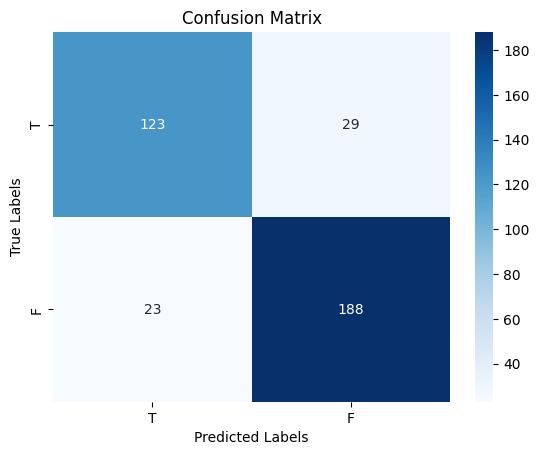

In [24]:
# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['T', 'F'])

# Display the confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['T', 'F'], yticklabels=['T', 'F'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 6.4 Forth Fold

In [8]:
# Specify the file path
excel_file_path = '/content/testing_scenario_split_4.xlsx'

# Read the Excel file into a DataFrame
df_testing_scenario_split_4 = pd.read_excel(excel_file_path)

# Display the DataFrame
df_testing_scenario_split_4.head()

,ID,Comment,sent,type,labels
0,611,Shife si esht ulur nje her si mushk 😡😡idijote ...,"Shife si eshte ulur njehere, si mushk. Idiote ...",Dating show,T
1,887,Erisoni shum intrigant ! Si silleshte ne filli...,Erisoni shume intrigant! Si silleshe ne fillim...,Dating show,T
2,871,Anisa shtige te dali nga programi,Anisa shtrige! Te dali nga programi!,Dating show,T
3,417,"Cfare xhelozie qesharake, znj Zhulali ! Fjale ...","Cfare xhelozie qesharake, znj Zhulali ! Fjale ...",Politics,F
4,352,SHIKONI SI E NZOREN KOKEN E QELBUR KETO 3 ANTI...,Shikoni si e nxorren koken e qelbur keto tre a...,Politics,T


In [26]:
fine_tuned_model_id = 'ft:gpt-3.5-turbo-0125:personal:allsplit4:9NGsOPVt'
store_predictions(df_testing_scenario_split_4, fine_tuned_model_id)
predictions_df = pd.read_csv("predictions.csv")

In [13]:
predicted_labels.unique()

array(['T', 'F'], dtype=object)

In [22]:
true_labels = predictions_df['labels'].replace('f', 'F')
predicted_labels = predictions_df['Prediction']

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"Precision: {precision:.4f}")

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"Recall: {recall:.4f}")

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.7934
Precision: 0.7059
Recall: 0.8684
F1 Score: 0.7788


In [23]:
# Get unique categories from the 'type' column
categories = predictions_df['type'].unique()

# Initialize dictionaries to store metrics for each category
accuracy_dict = {}
precision_dict = {}
recall_dict = {}
f1_dict = {}

# Calculate metrics for each category
for category in categories:
    category_indices = predictions_df['type'] == category
    category_true_labels = true_labels[category_indices]
    category_predicted_labels = predicted_labels[category_indices]

    # Calculate accuracy
    accuracy = accuracy_score(category_true_labels, category_predicted_labels)
    accuracy_dict[category] = accuracy

    # Calculate precision
    precision = precision_score(category_true_labels, category_predicted_labels, average='binary', pos_label='T')
    precision_dict[category] = precision

    # Calculate recall
    recall = recall_score(category_true_labels, category_predicted_labels, average='binary',pos_label='T')
    recall_dict[category] = recall

    # Calculate F1 score
    f1 = f1_score(category_true_labels, category_predicted_labels, average='binary', pos_label='T')
    f1_dict[category] = f1

# Print metrics for each category
for category in categories:
    print(f"Category: {category}")
    print(f"Accuracy: {accuracy_dict[category]:.4f}")
    print(f"Precision: {precision_dict[category]:.4f}")
    print(f"Recall: {recall_dict[category]:.4f}")
    print(f"F1 Score: {f1_dict[category]:.4f}")
    print()

Category: Dating show
Accuracy: 0.8512
Precision: 0.7887
Recall: 0.9492
F1 Score: 0.8615

Category: Politics
Accuracy: 0.7311
Precision: 0.6230
Recall: 0.8085
F1 Score: 0.7037

Category: Actuality
Accuracy: 0.7967
Precision: 0.6909
Recall: 0.8261
F1 Score: 0.7525



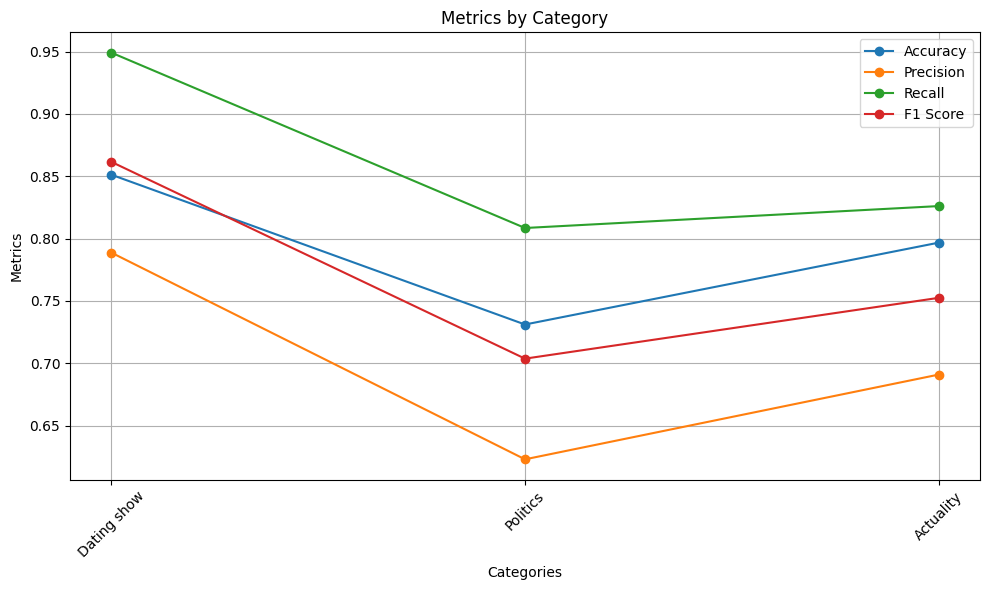

In [35]:

# Load the CSV file into a DataFrame
predictions_df = pd.read_csv("predictions.csv")

# Replace 'f' with 'F' in the 'labels' column
predictions_df['labels'] = predictions_df['labels'].replace('f', 'F')

# Get unique categories from the 'type' column
categories = predictions_df['type'].unique()

# Initialize dictionaries to store metrics for each category
accuracy_dict = {}
precision_dict = {}
recall_dict = {}
f1_dict = {}

# Calculate metrics for each category
for category in categories:
    category_indices = predictions_df['type'] == category
    category_true_labels = predictions_df[category_indices]['labels']
    category_predicted_labels = predictions_df[category_indices]['Prediction']

    # Calculate accuracy
    accuracy = accuracy_score(category_true_labels, category_predicted_labels)
    accuracy_dict[category] = accuracy

    # Calculate precision
    precision = precision_score(category_true_labels, category_predicted_labels, pos_label='T')
    precision_dict[category] = precision

    # Calculate recall
    recall = recall_score(category_true_labels, category_predicted_labels, pos_label='T')
    recall_dict[category] = recall

    # Calculate F1 score
    f1 = f1_score(category_true_labels, category_predicted_labels, pos_label='T')
    f1_dict[category] = f1

# Create a line chart
fig, ax = plt.subplots(figsize=(10, 6))

index = range(len(categories))

ax.plot(categories, accuracy_dict.values(), marker='o', label='Accuracy')
ax.plot(categories, precision_dict.values(), marker='o', label='Precision')
ax.plot(categories, recall_dict.values(), marker='o', label='Recall')
ax.plot(categories, f1_dict.values(), marker='o', label='F1 Score')

ax.set_xlabel('Categories')
ax.set_ylabel('Metrics')
ax.set_title('Metrics by Category')
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


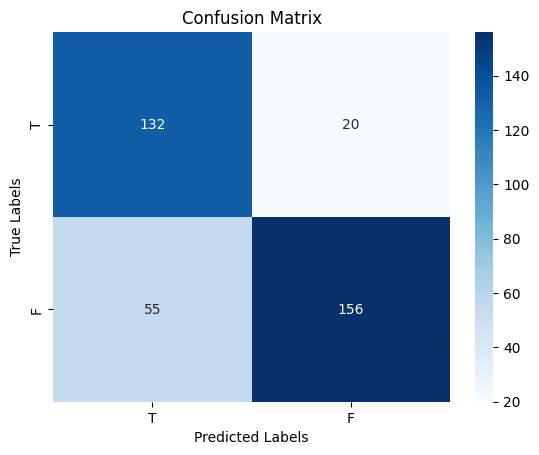

In [24]:
# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['T', 'F'])

# Display the confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['T', 'F'], yticklabels=['T', 'F'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#6.5 Overall Metrics

In [26]:
# Accuracy values
accuracy_values = [0.8264, 0.8457, 0.8567, 0.7934]

# average and standard deviation
average_accuracy = np.mean(accuracy_values)
std_dev_accuracy = np.std(accuracy_values)

# Print the results
print(f"Average Accuracy: {average_accuracy:.4f}")
print(f"Standard Deviation of Accuracy: {std_dev_accuracy:.4f}")

Average Accuracy: 0.8306
Standard Deviation of Accuracy: 0.0240


##7. Analysis of results for all topics

# 7.1 ROC Curve (best and worst performing fold)

In [13]:
predictions_df = pd.read_csv("predictions_split4.csv")
y_true = predictions_df['labels']
y_pred = predictions_df['Prediction']

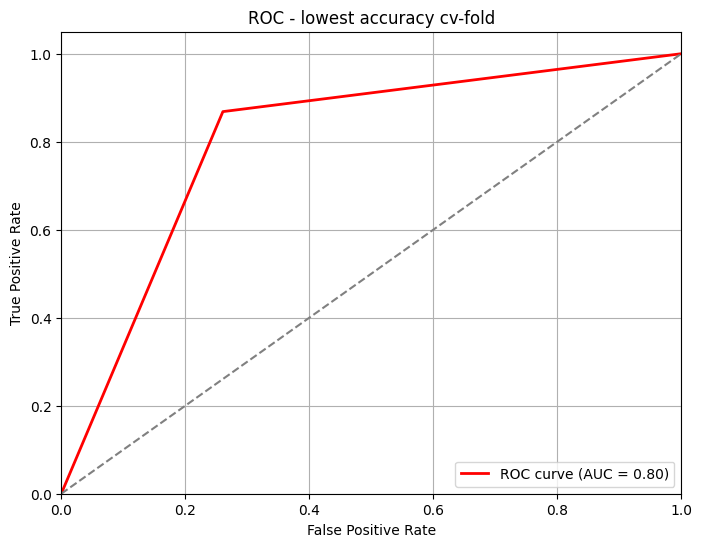

In [14]:
y_true_binary = np.where(y_true == 'T', 1, 0)
y_pred_binary = np.where(y_pred == 'T', 1, 0)
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred_binary)

# Calculate the area under the ROC curve
roc_auc = roc_auc_score(y_true_binary, y_pred_binary)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - lowest accuracy cv-fold')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [15]:
predictions_df = pd.read_csv("predictions_split3.csv")
y_true = predictions_df['labels']
y_pred = predictions_df['Prediction']

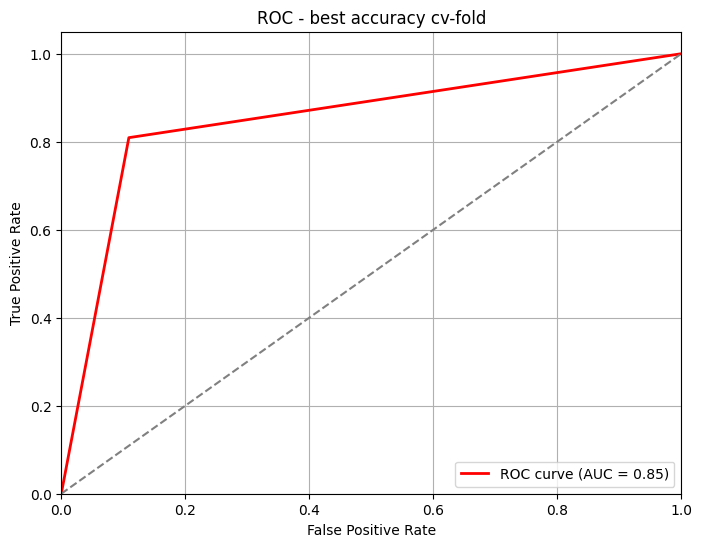

In [16]:
y_true_binary = np.where(y_true == 'T', 1, 0)
y_pred_binary = np.where(y_pred == 'T', 1, 0)
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred_binary)

# Calculate the area under the ROC curve
roc_auc = roc_auc_score(y_true_binary, y_pred_binary)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - best accuracy cv-fold')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 7.2 Linguistic analysis of FP and FN

In [20]:
# consider the fold that has the lowest accuracy
df = pd.read_csv("/content/predictions_split4.csv")

# Filter false positives
false_positives_df = df[(df['labels'] == 'F') & (df['Prediction'] == 'T')]
false_positives_df.to_excel('false_positives.xlsx', index=False)

# Filter false negatives
false_negatives_df = df[(df['labels'] == 'T') & (df['Prediction'] == 'F')]
false_negatives_df.to_excel('false_negatives.xlsx', index=False)

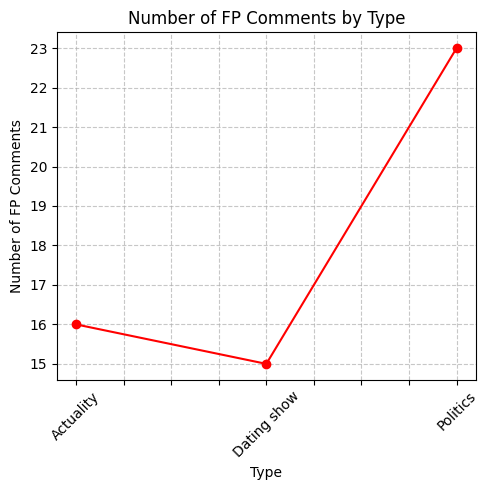

In [23]:
# Group the DataFrame by 'type' and sum the 'FP' values for each type
fp_counts = false_positives_df.groupby('type').size()

# Plotting
plt.figure(figsize=(5, 5))
fp_counts.plot(kind='line', marker='o', color='red', linestyle='-')
plt.title('Number of FP Comments by Type')
plt.xlabel('Type')
plt.ylabel('Number of FP Comments')
plt.xticks(rotation=45)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

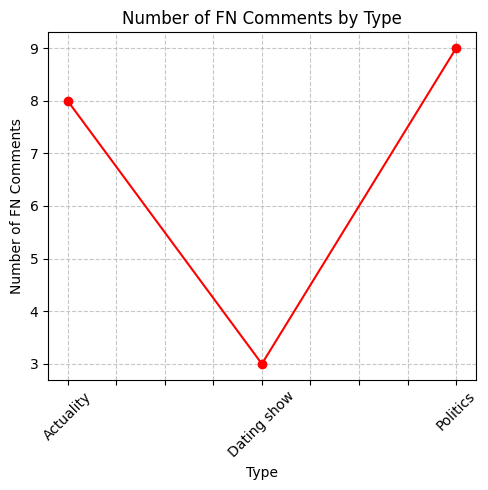

In [24]:
# Group the DataFrame by 'type' and sum the 'FP' values for each type
fp_counts = false_negatives_df.groupby('type').size()

# Plotting
plt.figure(figsize=(5,5))
fp_counts.plot(kind='line', marker='o', color='red', linestyle='-')
plt.title('Number of FN Comments by Type')
plt.xlabel('Type')
plt.ylabel('Number of FN Comments')
plt.xticks(rotation=45)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [26]:
#False Positives
compare_encodings("ferra")



Example string: "ferra"

cl100k_base: 2 tokens
token integers: [69, 14210]
token bytes: [b'f', b'erra']


In [27]:
compare_encodings("perra")


Example string: "perra"

cl100k_base: 2 tokens
token integers: [79, 14210]
token bytes: [b'p', b'erra']
